confusion matrix, prioritise nearer dims/other induxtive biases?, 

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import scipy
import seaborn as sns

# Data Loading

In [2]:
X = pd.read_csv('anton schwarz - MNIST_train.csv', index_col=None)

In [3]:
X = X.drop(['Unnamed: 0', 'index'], axis=1)


In [4]:
X = X.to_numpy()

In [5]:
y = X[:,0]
X = X[:,1:]

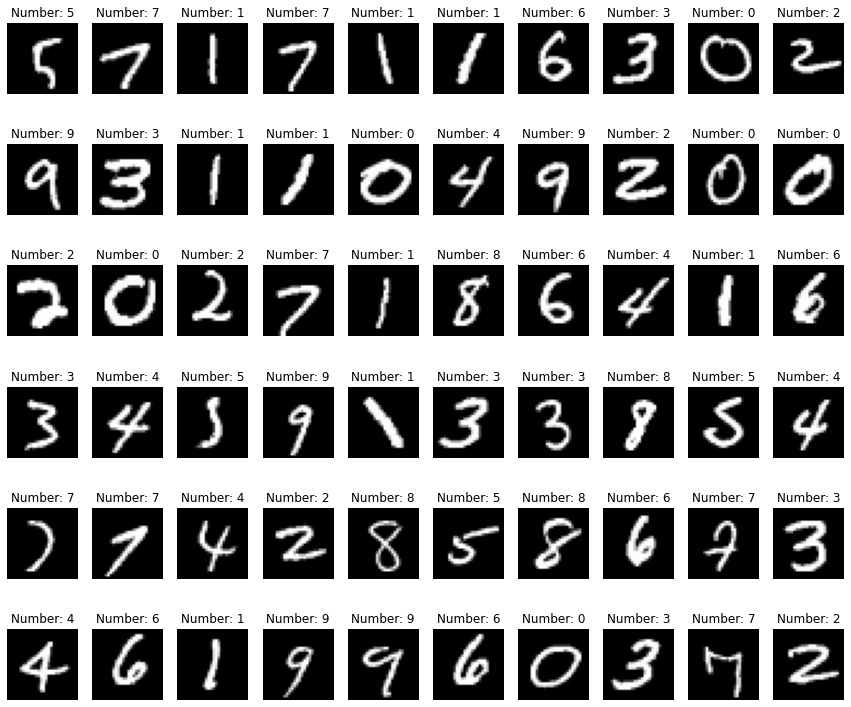

In [34]:
plt.figure(figsize=(15,13))
for index, (image, label) in enumerate(zip(X[100:160], y[100:160])):
    plt.subplot(6, 10, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap="gray")
    plt.title("Number: %s" % label)
    plt.axis('off')

In [6]:
def get_train_val(X,y,split=0.2):
    val_indices = np.random.choice(len(X), int(len(X)*split), replace=False)
    train_indices = np.delete(np.arange(len(X)), val_indices)
    val_X = X[val_indices]
    val_y = y[val_indices]
    train_X = X[train_indices]
    train_y = y[train_indices]
    return train_X, train_y, val_X, val_y

In [7]:
train_X, train_y, val_X, val_y = get_train_val(X, y)

In [35]:
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(48000, 784) (48000,) (12000, 784) (12000,)


In [10]:
def plot(invector):
    plt.imshow(invector.reshape((28,28)))

6


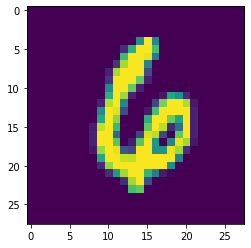

In [36]:
print(train_y[30])
plot(train_X[30])

# Preprocessing
normalise, whiten?, 

In [81]:
stds = train_X.std(axis=0)

In [82]:
means = train_X.mean(axis = 0)

In [83]:
normalised_train_X = (train_X - means)/(stds +1e-3) 

In [85]:
normalised_val_X = (val_X -means)/(stds+1e-3)

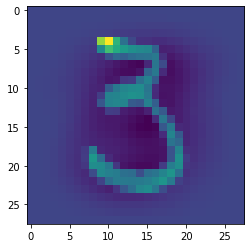

In [86]:
plot(normalised_val_X[7])

# Model

In [38]:
def accuracy(y,y_hat):
    return np.mean(y==y_hat)

In [39]:
class GaussBayes():

    def fit(self, X, y, epsilon=1e-3):

        self.likelihoods = dict()
        self.priors = dict()
        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y==k,:]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis=0)

            self.likelihoods[k]={"mean": X_k.mean(axis=0), 'cov': (1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+ epsilon*np.identity(D)}
            self.priors[k] = len(X_k)/len(X)

    def predict(self, X, dist=mvn.logpdf):

        N,D = X.shape
        P_hat = np.zeros((N, len(self.K)))

        for k,l in self.likelihoods.items():
            P_hat[:,k] = dist(X, l['mean'], l['cov'])+np.log(self.priors[k])

        return P_hat.argmax(axis=1)

In [13]:
def fit_predict(model, X, y, sampler):
    model = model()
    train_X, train_y, val_X, val_y = sampler(X,y)
    model.fit(train_X,train_y)
    y_hat = model.predict(val_X)

In [ ]:
accuracies = []
for i in range(tests):
    model = model()
    train_X, train_y, val_X, val_y = get_train_val(X,y)
    model.fit(train_X,train_y)
    y_hat = model.predict(val_X)
    accuracies.append(accuracy(y_hat, val_y))
    return accuracies

In [105]:
gb = GaussBayes()
gb.fit(normalised_train_X, train_y)
y_hat = gb.predict(normalised_val_X)
accuracy(y_hat, val_y)

0.5759

In [41]:
gb = GaussBayes()
gb.fit(X, y)
y_hat = gb.predict(X)
accuracy(y_hat, y)

0.78565

In [52]:
gb2 = GaussBayes()
gb2.fit(train_X, train_y)
y_hat = gb2.predict(val_X)
accuracy(y_hat, val_y)

0.7548333333333334

In [112]:
y_hat = gb2.predict(val_X, dist = scipy.stats.multivariate_t.logpdf)
accuracy(y_hat, val_y)

0.8095

# Results

In [ ]:
plt.figure(figsize=(10,7))
y_actu = pd.Series(y, name='Actual')
y_pred = pd.Series(y_hat, name='Predicted')
cm = pd.crosstab(y_actu, y_pred)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 42.0, 'Prediction')

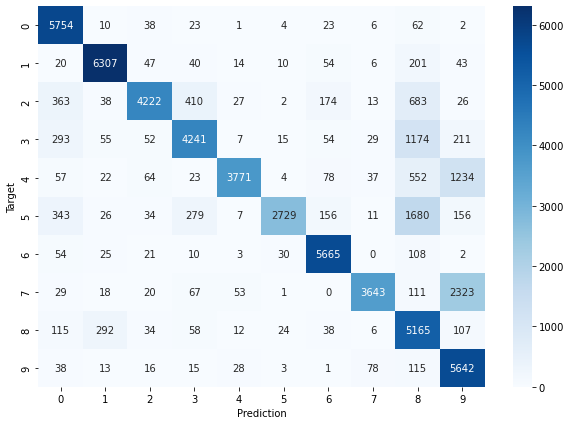

In [46]:
plt.figure(figsize=(10,7))
target = pd.Series(y, name='Target')
y_pred = pd.Series(y_hat, name='Prediction')
cm = pd.crosstab(target, y_pred)
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt="d")
plt.ylabel('Target')
plt.xlabel('Prediction')